In [1]:
import os
import csv
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from tqdm.notebook import tqdm

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

import sys
sys.path.append("..")
import data
import models
import inference

%load_ext autoreload
%autoreload 2

In [2]:
def kms2slowness(kms):
    kmh = kms * 3600
    ms = kmh * 1000 / 3600
    return 1 / ms

def kmh2slowness(kmh):
    ms = kmh * 1000 / 3600
    return 1 / ms

def rv(true, pred):
    return np.mean((true - pred)**2, axis=-1) / (np.mean(true**2, axis=-1))

def confidence_interval(arr):
    return 1.96 * np.std(arr) / np.sqrt(len(arr))

def add_row(data, file_path, header=None):
    with open(file_path, 'a+', newline='') as file:
        writer = csv.writer(file)
        file.seek(0)
        if file.readable() and file.read(1) == '':
            if header is not None:
                writer.writerow(header)
        writer.writerow(data)

In [3]:
dx = 4
fs = 50

eq_test = torch.from_numpy(np.load('../data/preprocessed/SIS-rotated_test_50Hz.npy'))
traffic_inc_test = torch.from_numpy(np.stack([np.load('../data/preprocessed/traffic_test_50Hz_{:02d}_inc.npy'.format(i)) for i in range(4)]))
traffic_dec_test = torch.from_numpy(np.stack([np.load('../data/preprocessed/traffic_test_50Hz_{:02d}_dec.npy'.format(i)) for i in range(4,8)]))

eq_test /= eq_test.std(dim=-1, keepdim=True)
traffic_inc_test /= traffic_inc_test.std(dim=-1, keepdim=True)
traffic_dec_test /= traffic_dec_test.std(dim=-1, keepdim=True)

eq_slowness=(1e-4, 5e-3)
traffic_slowness=(3e-2, 6e-2)

def get_sample(snr):
    
    idx = np.random.choice(len(eq_test))
    slowness = np.random.uniform(*eq_slowness)
    if np.random.random() < 0.5:
        slowness *= -1
    
    master = eq_test[idx]
    if np.random.random() < 0.5:
        master = torch.flip(master, dims=(0,))
    if np.random.random() < 0.5:
        master *= -1
    
    eq = data.generate_synthetic_das(master, dx, fs, slowness, nx=500)[:,3500:6500]
    eq /= eq.std(dim=-1, keepdim=True)

    
    gutter = 100
    idx = np.random.choice(len(traffic_dec_test))
    slowness = np.random.uniform(*traffic_slowness)
    t = np.random.randint(gutter, 9000-3000-gutter+1)
    traffic = data.shift_traffic_rates(traffic_dec_test[idx], dx, fs, -slowness)[:500,t-gutter:t+3000+gutter]
    idx = np.random.choice(len(traffic_inc_test))
    slowness = np.random.uniform(*traffic_slowness)
    t = np.random.randint(gutter, 9000-3000-gutter+1)
    traffic += data.shift_traffic_rates(traffic_inc_test[idx], dx, fs, slowness)[:500,t-gutter:t+3000+gutter]

    traffic = torch.from_numpy(data.bandpass(traffic, 1.0, 10.0, fs, 100).copy())
    traffic /= traffic.std(dim=-1, keepdim=True)
    
    return eq, traffic

In [ ]:
snr = 10

eq, traffic = get_sample(snr)
amp = np.sqrt(snr)
sample = amp*eq + traffic
scale = sample.std(dim=-1, keepdim=True)
sample /= scale

fig, axs = plt.subplot_mosaic([['a']], layout='constrained', figsize=(12,8))
axs['a'].imshow(sample, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.show()

In [5]:
if not os.path.isfile('./out/quantitative_evaluation_-2_1_complement.csv'):

    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-synthetic4-complement-128x512-16x180_200.pt'))
    model.eval()

    snrs = 10 ** np.linspace(-2, 1, 30)
    for snr in tqdm(snrs, position=0):
        res = []
        for i in tqdm(range(100), position=1):
            eq, traffic = get_sample(snr)
            amp = np.sqrt(snr)
            sample = amp*eq + traffic
            scale = sample.std(dim=-1, keepdim=True)
            sample /= scale
            
            rec = inference.xreconstruct(model, sample, 128, 512, 16, 
                                            nx_stride=16//4, nt_stride=180//4, 
                                            batch_size=128, dx=dx, fs=fs).detach().cpu().numpy()
            
            rec_filt = data.bandpass(np.pad(rec, ((0,0),(100,100))), 1.0, 10.0, fs, 100).copy()
            
            tmp1 = np.mean(((amp*eq/scale).numpy() - rec)**2, axis=-1)
            tmp2 = rv((amp*eq/scale).numpy(), rec)
            tmp1_filt = np.mean(((amp*eq/scale).numpy() - rec_filt)**2, axis=-1)
            tmp2_filt = rv((amp*eq/scale).numpy(), rec_filt)
            res.append([np.mean(tmp1), np.std(tmp1), confidence_interval(tmp1), np.mean(tmp1_filt), np.std(tmp1_filt), confidence_interval(tmp1_filt),
                        np.mean(tmp2), np.std(tmp2), confidence_interval(tmp2), np.mean(tmp2_filt), np.std(tmp2_filt), confidence_interval(tmp2_filt)])

        res = np.mean(res, axis=0)
        add_row([snr] + res.tolist(), "./out/quantitative_evaluation_-2_1_complement.csv")

In [6]:
if not os.path.isfile('./out/quantitative_evaluation_-2_1_center.csv'):
    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-synthetic4-center-128x512-16x180_200.pt'))
    model.eval()

    snrs = 10 ** np.linspace(-2, 1, 30)
    for snr in tqdm(snrs, position=0):
        res = []
        for i in tqdm(range(100), position=1):
            eq, traffic = get_sample(snr)
            amp = np.sqrt(snr)
            sample = amp*eq + traffic
            scale = sample.std(dim=-1, keepdim=True)
            sample /= scale
            
            rec = utils.inference.xreconstruct(model, sample, 128, 512, 16, 
                                            nx_stride=16//4, nt_stride=180//4, 
                                            batch_size=128, dx=dx, fs=fs).detach().cpu().numpy()
            
            rec_filt = utils.data.bandpass(np.pad(rec, ((0,0),(100,100))), 1.0, 10.0, fs, 100).copy()
            
            tmp1 = np.mean(((amp*eq/scale).numpy() - rec)**2, axis=-1)
            tmp2 = rv((amp*eq/scale).numpy(), rec)
            tmp1_filt = np.mean(((amp*eq/scale).numpy() - rec_filt)**2, axis=-1)
            tmp2_filt = rv((amp*eq/scale).numpy(), rec_filt)
            res.append([np.mean(tmp1), np.std(tmp1), confidence_interval(tmp1), np.mean(tmp1_filt), np.std(tmp1_filt), confidence_interval(tmp1_filt),
                        np.mean(tmp2), np.std(tmp2), confidence_interval(tmp2), np.mean(tmp2_filt), np.std(tmp2_filt), confidence_interval(tmp2_filt)])

        res = np.mean(res, axis=0)
        add_row([snr] + res.tolist(), "./out/quantitative_evaluation_-2_1_center.csv")

In [ ]:
model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
model.load_state_dict(torch.load('../ckpt/CN2S-synthetic4-complement-128x512-16x180_200.pt'))
model.eval()

np.random.seed(42)


# 1e-4 to 5e-3 -- 0.2 to 10
eq = data.generate_synthetic_das(eq_test[4], dx, fs, kms2slowness(3), nx=500)[:,4300:7300]
#eq = torch.from_numpy(utils.data.bandpass(eq, 1.0, 10.0, fs, 100).copy())
eq /= eq.std(dim=-1, keepdim=True)

traffic = data.shift_traffic_rates(traffic_dec_test[0], dx, fs, -kmh2slowness(80))[:500,100:3300]
traffic += data.shift_traffic_rates(traffic_inc_test[2], dx, fs, kmh2slowness(100))[:500,1900:5100]

traffic = torch.from_numpy(data.bandpass(traffic, 1.0, 10.0, fs, 100).copy())
traffic /= traffic.std(dim=-1, keepdim=True)

snr = 0.5
amp = np.sqrt(snr)
sample = amp * eq  + traffic
scale = sample.std(dim=-1, keepdim=True)
sample /= scale

fig, axs = plt.subplot_mosaic([['a']], layout='constrained', figsize=(12,8))
axs['a'].imshow(sample, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.show()

rec = inference.xreconstruct(model, sample, 128, 512, 16, 
                             nx_stride=16//4, nt_stride=180//4, 
                             batch_size=128, dx=dx, fs=fs, verbose=False).detach().cpu().numpy()

rec_filt = data.bandpass(np.pad(rec, ((0,0),(100,100))), 1.0, 10.0, fs, 100).copy()

fig, axs = plt.subplot_mosaic([['a']], layout='constrained', figsize=(12,8))
axs['a'].imshow(rec_filt, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.show()

In [8]:
df = pd.read_csv("./out/quantitative_evaluation_-2_1_complement.csv", header=None)
snrs1 = df[0].to_numpy()
means1 = df[7].to_numpy() # 7 10
cis1 = df[9].to_numpy() # 9 11

df = pd.read_csv("./out/quantitative_evaluation_-2_1_center.csv", header=None)
snrs2 = df[0].to_numpy()
means2 = df[7].to_numpy()
cis2 = df[9].to_numpy()

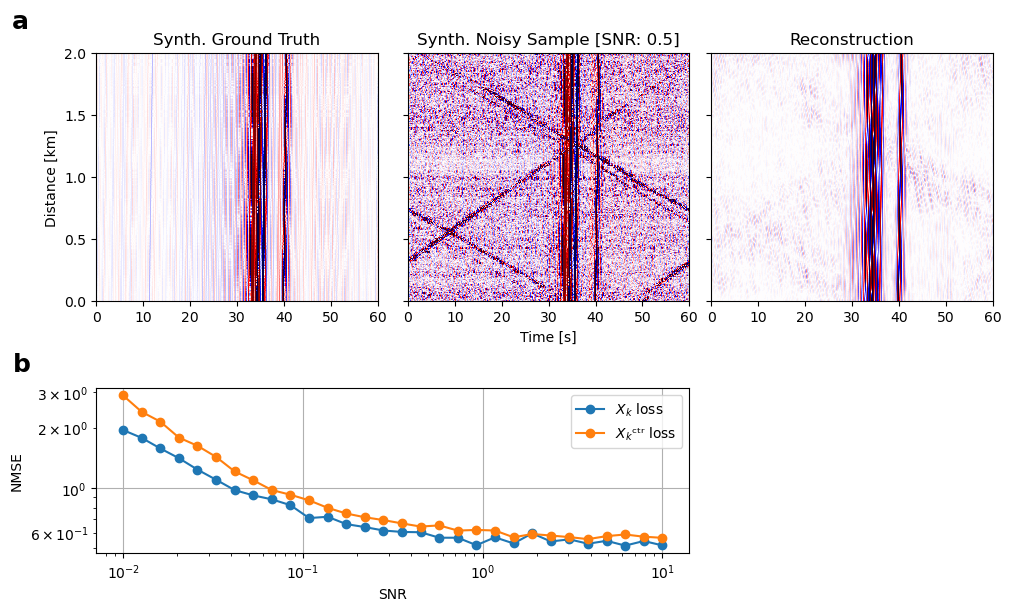

In [9]:
fig, axs = plt.subplot_mosaic([['a','b','c'],
                               ['a','b','c'],
                               ['a','b','c'],
                               ['d','d','_'],
                               ['d','d','_']], layout='constrained', figsize=(10,6))

axs['a'].imshow(eq, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
axs['b'].imshow(sample*(scale/amp).numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
axs['c'].imshow(rec_filt*(scale/amp).numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

x = np.array(snrs1)
y = np.array(means1)
z = np.array(cis1)
axs['d'].loglog(x, y, marker='o', color='tab:blue', label=r'$X_k$ loss')
#axs['d'].fill_between(x, y - z, y + z, alpha=0.25, color='tab:blue')

x = np.array(snrs2)
y = np.array(means2)
z = np.array(cis2)
axs['d'].loglog(x, y, marker='o', color='tab:orange', label=r'$X_k$'+'\u1D9C\u1D57\u02B3 loss')
#axs['d'].fill_between(x, y - z, y + z, alpha=0.25, color='tab:orange')

axs['d'].grid()

for s in ['a', 'b', 'c']:
    axs[s].set_xticks([i for i in range(0,3001,500)])
    axs[s].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))
    
    axs[s].set_yticks([i for i in range(0,501,125)])
    axs[s].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{(x * 0.004)}')) 
    
axs['b'].set_yticklabels([])
axs['c'].set_yticklabels([])

axs['b'].set_xlabel('Time [s]')
axs['a'].set_ylabel('Distance [km]')

axs['d'].set_xlabel('SNR')
axs['d'].set_ylabel('NMSE')

axs['a'].set_title('Synth. Ground Truth')
axs['b'].set_title('Synth. Noisy Sample [SNR: 0.5]')
axs['c'].set_title('Reconstruction')

axs['d'].legend()

axs['a'].text(-0.3, 1.1, 'a', transform=axs['a'].transAxes, size=18, weight='bold')
axs['d'].text(-0.14, 1.1, 'b', transform=axs['d'].transAxes, size=18, weight='bold')

axs['_'].axis('off')
plt.savefig('./out/figure_07.pdf', bbox_inches='tight', dpi=200)
plt.show()